# Explanation
Samples are generated as a "poisson random walk" where the CN in first state is random poisson, and then the following CN=CN+jump where jump is a poisson random variable. Two clusters were simulated using different jump, initialization parameters and then they were clustered.

/Users/massoudmaher/Documents/Code/scgenome/venv/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/massoudmaher/Documents/Code/scgenome/venv/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


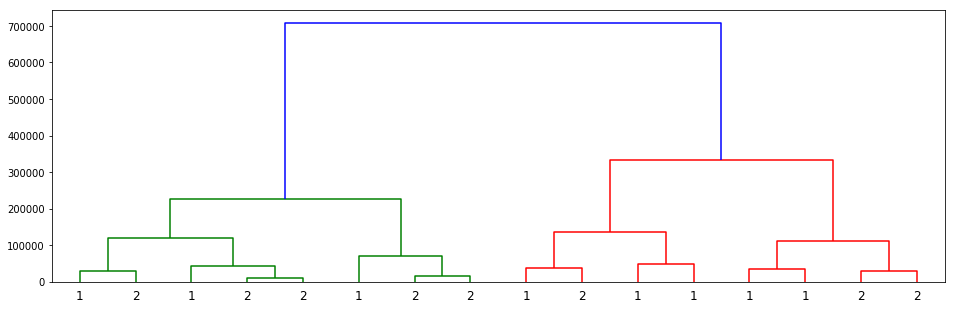

In [38]:
import scgenome.simulation as sim
import numpy as np
import pandas as pd
from IPython.display import display
from scgenome import cncluster
from scgenome.utils import cn_mat_to_cn_data, cn_mat_as_df
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

NUM_SAMPLE = 8
NUM_BIN = 500
CHR_NAMES = ["1","2"]
max_cn=7

cluster1 = sim.cn_mat_poisson(NUM_SAMPLE, NUM_BIN, init_lambda=1., jump_lambda=1, seed=None, max_cn=max_cn)
cluster2 = sim.cn_mat_poisson(NUM_SAMPLE, NUM_BIN, init_lambda=3., jump_lambda=0.1, seed=None, max_cn=max_cn)

clst1_cell_ids = [f"cl1_cell{i}" for i in range(cluster1.shape[0])]
clst2_cell_ids = [f"cl2_cell{i}" for i in range(cluster1.shape[0])]

cn_mat = np.concatenate([cluster1, cluster2])
cell_ids = clst1_cell_ids + clst2_cell_ids

df_cn_mat = cn_mat_as_df(cn_mat,CHR_NAMES)
cn_data = cn_mat_to_cn_data(df_cn_mat, cell_id_vals=cell_ids)
cn_data["cluster_id"] = cn_data["cell_id"].str.split("_",expand=True).iloc[:,0]
cn_data["copy2"] = cn_data["copy"] + np.absolute(np.random.normal(size=cn_data.shape[0], scale=0.3))
cn_data.columns = ["chr", "bin", "cell_id", "state", "start", "end", "cluster_id", "copy"]

tlinkage, root, cl_cell_ids = cncluster.bayesian_cluster(cn_data, n_states=max_cn, value_ids=["copy"])

plinkage = tlinkage[["i","j","r_merge","merge_count"]]
plinkage["r_merge"] = plinkage["r_merge"].astype("float")
plinkage["dist"] = -1 * plinkage["r_merge"]
plot_data = plinkage[["i","j","dist","merge_count"]].to_numpy().astype("float")

cl_cell_ids = cl_cell_ids.str[2]
fig = plt.figure(figsize=(16, 5))
dend = dendrogram(plot_data, labels=cl_cell_ids)

# Analysis
Doesn't work too well. The y-axis is `-marginal_log_likelihood` and the values are quite high so I question it. Should be getting good clustering

In [39]:
clustering = pd.DataFrame()
clustering["sample_inds"] = list(range(cn_mat.shape[0]))
clustering["cell_id"] = cell_ids
clustering["exp_cl"] = clustering["cell_id"].str[2]

left_samples = [x.sample_inds[0] for x in root.left_child.get_leaves()]
right_samples = [x.sample_inds[0] for x in root.right_child.get_leaves()]


def fn(ind):
    if ind in left_samples:
        return "1"
    elif ind in right_samples:
        return "2"
clustering["obs_cl"] = clustering["sample_inds"].apply(fn)

def get_prop_correct(clustering):
    return max((clustering["exp_cl"] == clustering["obs_cl"]).value_counts() / clustering.shape[0])

print(f"proportion clustering: {get_prop_correct(clustering)}")

proportion clustering: 0.625


# Repeating over many trials

In [52]:
NUM_TRIALS = 100
NUM_SAMPLE = 8
NUM_BIN = 500
CHR_NAMES = ["1","2"]
MAX_CN=7

def simulate_bayes_cluster(df, num_sample=NUM_SAMPLE, num_bin=NUM_BIN, chr_names=CHR_NAMES, max_cn=MAX_CN):
    cluster1 = sim.cn_mat_poisson(num_sample, num_bin, init_lambda=1., jump_lambda=1, seed=None, max_cn=max_cn)
    cluster2 = sim.cn_mat_poisson(num_sample, num_bin, init_lambda=3., jump_lambda=0.1, seed=None, max_cn=max_cn)

    clst1_cell_ids = [f"cl1_cell{i}" for i in range(cluster1.shape[0])]
    clst2_cell_ids = [f"cl2_cell{i}" for i in range(cluster1.shape[0])]

    cn_mat = np.concatenate([cluster1, cluster2])
    df["cn_mat"] = cn_mat
    cell_ids = clst1_cell_ids + clst2_cell_ids

    df_cn_mat = cn_mat_as_df(cn_mat, chr_names)
    cn_data = cn_mat_to_cn_data(df_cn_mat, cell_id_vals=cell_ids)
    cn_data["cluster_id"] = cn_data["cell_id"].str.split("_",expand=True).iloc[:,0]
    cn_data["copy2"] = cn_data["copy"] + np.absolute(np.random.normal(size=cn_data.shape[0], scale=0.3))
    cn_data.columns = ["chr", "bin", "cell_id", "state", "start", "end", "cluster_id", "copy"]

    tlinkage, root, cl_cell_ids = cncluster.bayesian_cluster(cn_data, n_states=max_cn, value_ids=["copy"])

    plinkage = tlinkage[["i","j","r_merge","merge_count"]]
    plinkage["r_merge"] = plinkage["r_merge"].astype("float")
    plinkage["dist"] = -1 * plinkage["r_merge"]
    plot_data = plinkage[["i","j","dist","merge_count"]].to_numpy().astype("float")
    df["plot_data"] = plot_data
   
    clustering = pd.DataFrame()
    clustering["sample_inds"] = list(range(cn_mat.shape[0]))
    clustering["cell_id"] = cell_ids
    clustering["exp_cl"] = clustering["cell_id"].str[2]
    df["clustering"] = clustering

    left_samples = [x.sample_inds[0] for x in root.left_child.get_leaves()]
    right_samples = [x.sample_inds[0] for x in root.right_child.get_leaves()]

    def fn(ind):
        if ind in left_samples:
            return "1"
        elif ind in right_samples:
            return "2"
    clustering["obs_cl"] = clustering["sample_inds"].apply(fn)

    prop_correct = get_prop_correct(clustering)
    
    df["prop_correct"] = prop_correct    
    return df

sims = pd.DataFrame(list(range(NUM_TRIALS)), columns=["id"])
sims = sims.apply(simulate_bayes_cluster, axis=1)

/Users/massoudmaher/Documents/Code/scgenome/venv/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/massoudmaher/Documents/Code/scgenome/venv/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,id,cn_mat,plot_data,clustering,prop_correct
0,0,"[[3, 4, 5, 6, 5, 5, 1, 0, 1, 1, 1, 1, 1, 1, 1,...","[[10.0, 13.0, 10923.679580802993, 2.0], [11.0,...",sample_inds cell_id exp_cl obs_cl 0 ...,0.8750
1,1,"[[1, 0, 2, 3, 3, 3, 3, 4, 5, 5, 5, 3, 4, 4, 4,...","[[9.0, 15.0, 10273.05158566416, 2.0], [11.0, 1...",sample_inds cell_id exp_cl obs_cl 0 ...,0.7500
2,2,"[[1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 4, 5, 3, 6,...","[[12.0, 13.0, 13051.929380215128, 2.0], [9.0, ...",sample_inds cell_id exp_cl obs_cl 0 ...,0.5625
3,3,"[[2, 2, 0, 0, 1, 1, 2, 2, 2, 2, 0, 1, 2, 2, 0,...","[[9.0, 12.0, 13395.98566122696, 2.0], [8.0, 15...",sample_inds cell_id exp_cl obs_cl 0 ...,0.6875
4,4,"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,...","[[8.0, 14.0, 5075.042681280502, 2.0], [13.0, 1...",sample_inds cell_id exp_cl obs_cl 0 ...,0.7500


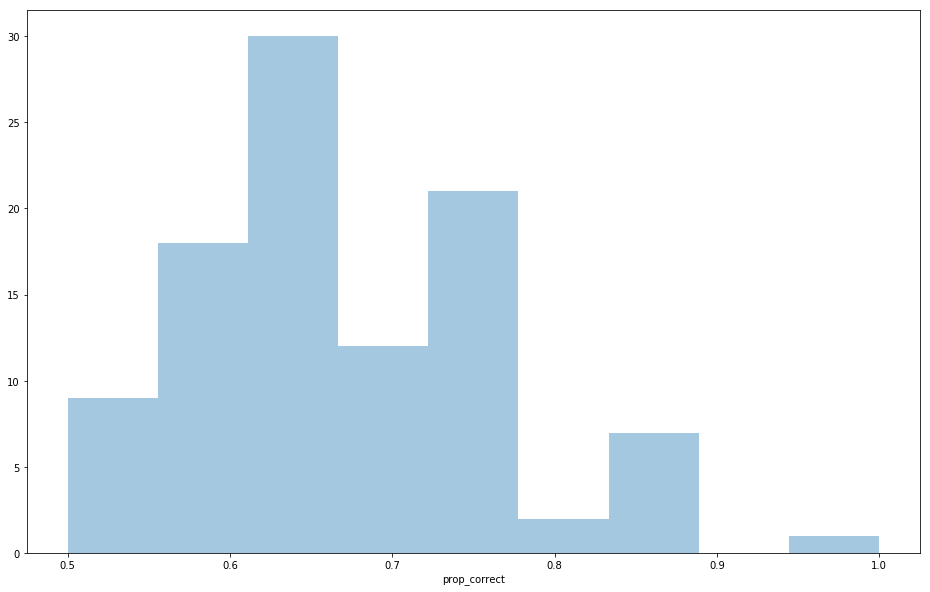

In [56]:
import seaborn as sns
display(sims.head())
fig = plt.figure(figsize=(16, 10))
sns.distplot(sims["prop_correct"], kde=False, bins=9)

In [3]:
import scgenome.simulation as sim
import numpy as np
import pandas as pd
from IPython.display import display
from scgenome import cncluster
from scgenome.utils import cn_mat_to_cn_data, cn_mat_as_df
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

NUM_SAMPLE = 8
NUM_BIN = 500
CHR_NAMES = ["1","2"]
max_cn=7

cluster1 = sim.cn_mat_poisson(NUM_SAMPLE, NUM_BIN, init_lambda=1., jump_lambda=1, seed=None, max_cn=max_cn)
cluster2 = sim.cn_mat_poisson(NUM_SAMPLE, NUM_BIN, init_lambda=3., jump_lambda=0.1, seed=None, max_cn=max_cn)

clst1_cell_ids = [f"cl1_cell{i}" for i in range(cluster1.shape[0])]
clst2_cell_ids = [f"cl2_cell{i}" for i in range(cluster1.shape[0])]

cn_mat = np.concatenate([cluster1, cluster2])
cell_ids = clst1_cell_ids + clst2_cell_ids

df_cn_mat = cn_mat_as_df(cn_mat,CHR_NAMES)
cn_data = cn_mat_to_cn_data(df_cn_mat, cell_id_vals=cell_ids)
cn_data["cluster_id"] = cn_data["cell_id"].str.split("_",expand=True).iloc[:,0]
cn_data["copy2"] = cn_data["copy"] + np.absolute(np.random.normal(size=cn_data.shape[0], scale=0.3))
cn_data.columns = ["chr", "bin", "cell_id", "state", "start", "end", "cluster_id", "copy"]

tlinkage, root, cl_cell_ids = cncluster.rec_bayesian_cluster(cn_data, n_states=max_cn, value_ids=["copy"])

plinkage = tlinkage[["i","j","r_merge","merge_count"]]
plinkage["r_merge"] = plinkage["r_merge"].astype("float")
plinkage["dist"] = -1 * plinkage["r_merge"]
plot_data = plinkage[["i","j","dist","merge_count"]].to_numpy().astype("float")
display(plinkage)

cl_cell_ids = cl_cell_ids.str[2]
fig = plt.figure(figsize=(16, 5))
dend = dendrogram(plot_data, labels=cl_cell_ids)

/Users/massoudmaher/Documents/Code/scgenome/venv/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/massoudmaher/Documents/Code/scgenome/venv/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,i,j,r_merge,merge_count,dist
0,11,12,1.000040,2,-1.000040
1,8,14,1.000020,2,-1.000020
2,13,15,1.000011,2,-1.000011
3,6,10,1.000010,2,-1.000010
4,2,5,1.000010,2,-1.000010
5,3,4,1.000010,2,-1.000010
6,0,1,1.000008,2,-1.000008
7,7,9,1.000006,2,-1.000006
8,22,23,-0.001013,4,0.001013
9,20,19,-0.001440,4,0.001440


ValueError: Linkage 'Z' contains negative distances.

<Figure size 1152x360 with 0 Axes>